In [2]:
import time
import tracemalloc

class TreeNode:  # Customized nodes for the Hirschberg recursion tree
    def __init__(self, indices, i_star, j_split, left_child=None, right_child=None):
        self.indices = indices
        self.i_star = i_star
        self.j_split = j_split
        self.left_child = left_child
        self.right_child = right_child

    def __repr__(self, level=0):  # Recursive tree visualization
        tree = "   " * level + f"{self.indices} ({self.i_star}, {self.j_split})\n"
        if self.left_child:
            tree += self.left_child.__repr__(level + 1)
        if self.right_child:
            tree += self.right_child.__repr__(level + 1)
        return tree


def forward(v, w, delta):
    len_w = len(w); len_v = len(v)
    M = [[None for j in range(len_w)] for i in range(len_v)]
    M[0][0] = 0
    for i in range(1, len_v):
        M[i][0] = M[i-1][0] + delta[v[i]]['-']
    for j in range(1, len_w):
        for i in range(0, len_v):
            if (i == 0):
                M[i][j] = M[i][j-1] + delta[w[j]]['-']
            else: 
                left_score = M[i][j - 1] + delta['-'][w[j]]
                top_score = M[i-1][j] + delta[v[i]]['-']
                M[i][j] = max(left_score, M[i-1][j-1] + delta[v[i]][w[j]], top_score)
            #clear value from colum no longer in use 
            if (j >= 2):
                M[i][j-2] = None
    columns = list(zip(*M))
    return columns[len_w - 1]

def backward(v, w, delta):
    len_w = len(w); len_v = len(v)
    M = [[None for j in range(len_w)] for i in range(len_v)]
    M[-1][-1] = 0
    for i in range(len_v - 2, -1, -1):
        M[i][len_w - 1] = M[i + 1][len_w-1] + delta[v[i]]['-']
    for j in range(len_w - 2, -1, -1):
        for i in range(len_v - 1, -1, -1):
            if (i == len(v) - 1):
                M[i][j] = M[i][j+1] + delta[v[i]]['-']
            else:
                """
                I changed the i and j into i+1 and j+1
                """
                left_score = M[i][j+1] + delta['-'][w[j+1]]
                top_score = M[i+1][j] + delta[v[i+1]]['-']
                M[i][j] = max(left_score, M[i+1][j+1] + delta[v[i+1]][w[j+1]], top_score)
            #clear value from column no longer in use
            if (j + 2 < len(w)):
                M[i][j + 2] = None
    columns = list(zip(*M))
    return columns[0]
    
def hirschberg_recurse(v, w, delta, i, j, i_prime, j_prime):
    v_adjusted = "-" + v
    w_adjusted = "-" + w
    if j_prime - j > 1:
        col_split = j + (j_prime - j) // 2
        prefixes = forward(v_adjusted[i:i_prime + 1], w_adjusted[j:col_split + 1], delta)
        suffixes = backward(v_adjusted[i:i_prime + 1], w_adjusted[col_split:j_prime + 1], delta)
        weights = [p + s for p, s in zip(prefixes, suffixes)]
        i_star = weights.index(max(weights))
        
        left = hirschberg_recurse(v, w, delta, i, j, i_star + i, col_split)
        right = hirschberg_recurse(v, w, delta, i_star + i, col_split, i_prime, j_prime)
        return TreeNode((i, j, i_prime, j_prime), i_star, col_split, left, right)
    else:
        """ 
        I changed the child into NULL pointer
        """
        return TreeNode((i, j, i_prime, j_prime), None, None)

def short_align(v_sub, w_sub):
    """
    Perform optimal alignment for short sequences using dynamic programming.
    This part is changed to figured out how to best align one character with a seq 
    (eg: A, TAT --> -A-, TAT)
    """
    len_v, len_w = len(v_sub), len(w_sub)
    
    # Initialize the scoring matrix for short sequences
    dp = [[0] * (len_w + 1) for _ in range(len_v + 1)]
    
    # Fill the scoring matrix
    for i in range(1, len_v + 1):
        dp[i][0] = dp[i - 1][0] + delta[v_sub[i - 1]]['-']
    for j in range(1, len_w + 1):
        dp[0][j] = dp[0][j - 1] + delta['-'][w_sub[j - 1]]
    for i in range(1, len_v + 1):
        for j in range(1, len_w + 1):
            match = dp[i - 1][j - 1] + delta[v_sub[i - 1]][w_sub[j - 1]]
            delete = dp[i - 1][j] + delta[v_sub[i - 1]]['-']
            insert = dp[i][j - 1] + delta['-'][w_sub[j - 1]]
            dp[i][j] = max(match, delete, insert)

    # Backtrack to construct alignment
    v_align, w_align = [], []
    i, j = len_v, len_w
    while i > 0 or j > 0:
        if i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + delta[v_sub[i - 1]][w_sub[j - 1]]:
            v_align.append(v_sub[i - 1])
            w_align.append(w_sub[j - 1])
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i - 1][j] + delta[v_sub[i - 1]]['-']:
            v_align.append(v_sub[i - 1])
            w_align.append("-")
            i -= 1
        else:
            v_align.append("-")
            w_align.append(w_sub[j - 1])
            j -= 1

    # Reverse the alignments and return as strings
    return "".join(reversed(v_align)), "".join(reversed(w_align))

 

def traceback_hirschberg(v, w, node, is_left_tree): 
    if not node:
        return "", ""
    i, j, i_prime, j_prime = node.indices

    # Base cases for empty sequences
    if i_prime - i == 0:
        return "-" * (j_prime - j), w[j:j_prime]
    if j_prime - j == 0:
        return v[i:i_prime], "-" * (i_prime - i)

    # Special cases for short sequences
    if i_prime - i == 1 or j_prime - j == 1:
        return short_align(v[i:i_prime], w[j:j_prime])

    # Recursive traceback for subtrees
    """
    I added a left and right difference, but i have no idea if this matter
    """
    if is_left_tree:
        v_left, w_left = traceback_hirschberg(v, w, node.left_child, True)
        v_right, w_right = traceback_hirschberg(v, w, node.right_child, False)
    else:
        v_right, w_right = traceback_hirschberg(v, w, node.right_child, False)
        v_left, w_left = traceback_hirschberg(v, w, node.left_child, True)


    return v_left + v_right, w_left + w_right


def hirschberg_with_root(v, w, delta):
    tracemalloc.start()
    start_time = time.time()

    root = hirschberg_recurse(v, w, delta, 0, 0, len(v), len(w))
    v_align, w_align = traceback_hirschberg(v, w, root, True)

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    elapsed_time = end_time - start_time
    alignment = f"{w_align}\n{v_align}"

    # Performance logging
    print(f"Memory usage:a Current = {current / 10**6:.6f} MB, Peak = {peak / 10**6:.6f} MB")
    print(f"Elapsed time: {elapsed_time:.6f} seconds")

    return alignment, elapsed_time, current, peak, root


In [3]:
keys = ['A', 'C', 'T', 'G', '-']
delta = {}
v = "TCGT"
w = "TACGGGG"

for i in range(len(keys)):
    delta[keys[i]] = {
        k: (0 if keys[i] == '-' and k == '-' else (1 if keys[i] == k else -1))
        for k in keys
    }
a, b, c, d, root = hirschberg_with_root(v, w, delta)
print(a)


Memory usage:a Current = 0.005408 MB, Peak = 0.005662 MB
Elapsed time: 0.001335 seconds
TACGGGG
T-C--GT


In [4]:
def print_tree_with_substrings(v, w, node, level=0):
    """
    Recursively print the tree structure, including substrings being processed.

    Args:
        node (TreeNode): The current node of the recursion tree.
        v (str): The first sequence being aligned.
        w (str): The second sequence being aligned.
        level (int): The current depth level of the node (used for indentation).
    """
    if node is None:
        # Handle leaf nodes
        indent = "    " * level
        print(f"{indent}Leaf: None")
        return

    # Extract indices and check validity
    try:
        i, j, i_prime, j_prime = node.indices
    except AttributeError:
        print(f"Error: Invalid node encountered at level {level}. Node: {node}")
        return

    indent = "    " * level  # Indentation based on the depth level
    print(f"{indent}Node: {node.indices}, i_star: {node.i_star}, j_split: {node.j_split}")
    print(f"{indent}  v_sub: '{v[i:i_prime]}'")
    print(f"{indent}  w_sub: '{w[j:j_prime]}'")

    # Recursively process children
    if node.left_child:
        print(f"{indent}Left:")
        print_tree_with_substrings(v, w, node.left_child, level + 1)
    if node.right_child:
        print(f"{indent}Right:")
        print_tree_with_substrings(v, w, node.right_child, level + 1)


In [5]:
print_tree_with_substrings(v, w, root)

Node: (0, 0, 4, 7), i_star: 2, j_split: 3
  v_sub: 'TCGT'
  w_sub: 'TACGGGG'
Left:
    Node: (0, 0, 2, 3), i_star: 1, j_split: 1
      v_sub: 'TC'
      w_sub: 'TAC'
    Left:
        Node: (0, 0, 1, 1), i_star: None, j_split: None
          v_sub: 'T'
          w_sub: 'T'
    Right:
        Node: (1, 1, 2, 3), i_star: 0, j_split: 2
          v_sub: 'C'
          w_sub: 'AC'
        Left:
            Node: (1, 1, 1, 2), i_star: None, j_split: None
              v_sub: ''
              w_sub: 'A'
        Right:
            Node: (1, 2, 2, 3), i_star: None, j_split: None
              v_sub: 'C'
              w_sub: 'C'
Right:
    Node: (2, 3, 4, 7), i_star: 0, j_split: 5
      v_sub: 'GT'
      w_sub: 'GGGG'
    Left:
        Node: (2, 3, 2, 5), i_star: 0, j_split: 4
          v_sub: ''
          w_sub: 'GG'
        Left:
            Node: (2, 3, 2, 4), i_star: None, j_split: None
              v_sub: ''
              w_sub: 'G'
        Right:
            Node: (2, 4, 2, 5), i_star: Non

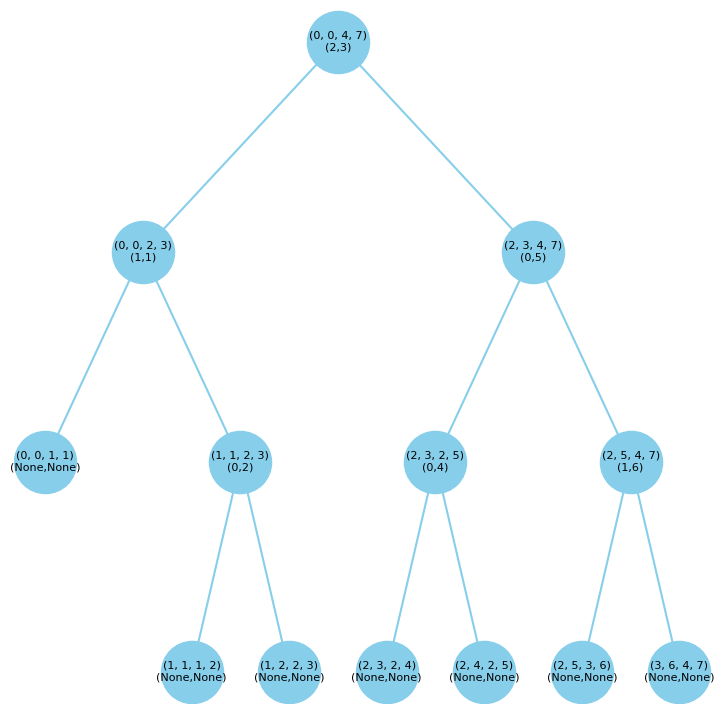

In [27]:
#alternative tree visualization (chat gtp really helped a lot with the code)
import matplotlib.pyplot as plt  

def calculate_positions(node, x=0, y=0, dx=1, positions=None, level=0):
    """Calculate positions for each node in the tree."""
    if positions is None:
        positions = {}
    if node is not None:
        positions[node] = (x, y)
        # Calculate positions for left and right children
        calculate_positions(node.left_child, x - dx, y - 1, dx / 2, positions, level + 1)
        calculate_positions(node.right_child, x + dx, y - 1, dx / 2, positions, level + 1)
    return positions

def draw_tree(node, positions, ax):
    """Draw the tree using Matplotlib."""
    for n, (x, y) in positions.items():
        # Plot the node with customized size and color
        ax.scatter(x, y, s=2000, color="skyblue", zorder=2)
        full_text = f"{n.indices}\n"+f"({n.i_star},{n.j_split})"
        ax.text(x, y, full_text, ha="center", va="center", fontsize=8, color="black")
        # Draw edges to children
        if n.left_child:
            x_left, y_left = positions[n.left_child]
            ax.plot([x, x_left], [y, y_left], color="skyblue")
        if n.right_child:
            x_right, y_right = positions[n.right_child]
            ax.plot([x, x_right], [y, y_right], color="skyblue")

def visualize_tree(root):
    fig, ax = plt.subplots(figsize=(9, 9))
    positions = calculate_positions(root)
    draw_tree(root, positions, ax)
    ax.axis("off")
    plt.show()

%matplotlib inline
visualize_tree(root)
